In [ ]:
!git clone https://github.com/MicheleCattaneo/ant_colony_opt_TSP.git

Cloning into 'ant_colony_opt_TSP'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 151 (delta 75), reused 107 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 4.41 MiB | 7.89 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
cd ant_colony_opt_TSP

/content/ant_colony_opt_TSP



=== Running 6 iterations with fixed initial tour, varying alpha and temp separately ===

--- Varying Alpha Experiments ---
Running with config: Alpha=0.99 (Slow)
  Distance: 1476.10 | Time: 104.75s


<ipython-input-4-f780f7c44975>:84: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


GIF saved as sa_alpha_1.gif
Running with config: Alpha=0.95 (Medium)
  Distance: 1982.64 | Time: 22.45s
GIF saved as sa_alpha_2.gif
Running with config: Alpha=0.90 (Fast)
  Distance: 2213.59 | Time: 10.58s
GIF saved as sa_alpha_3.gif

--- Varying Temperature Experiments ---
Running with config: Temp=200 (Low)
  Distance: 1952.89 | Time: 15.49s
GIF saved as sa_temp_1.gif
Running with config: Temp=1000 (Mid)
  Distance: 2073.01 | Time: 23.61s
GIF saved as sa_temp_2.gif
Running with config: Temp=5000 (High)
  Distance: 1871.44 | Time: 31.47s
GIF saved as sa_temp_3.gif

=== Running 5 iterations with random initial tours ===
Running Iteration #1...
  Distance: 1986.25 | Time: 23.16s
GIF saved as sa_random_1.gif
Running Iteration #2...
  Distance: 1920.12 | Time: 18.24s
GIF saved as sa_random_2.gif
Running Iteration #3...
  Distance: 1845.21 | Time: 24.62s
GIF saved as sa_random_3.gif
Running Iteration #4...
  Distance: 1937.46 | Time: 20.64s
GIF saved as sa_random_4.gif
Running Iteration #5

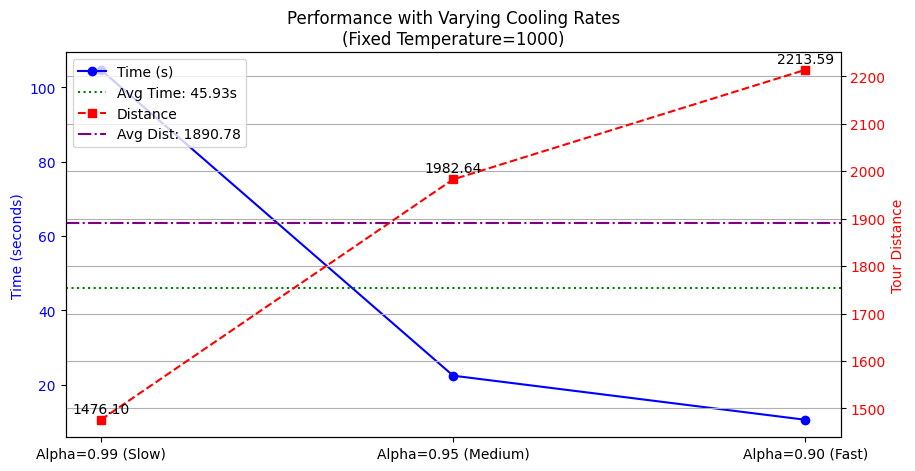

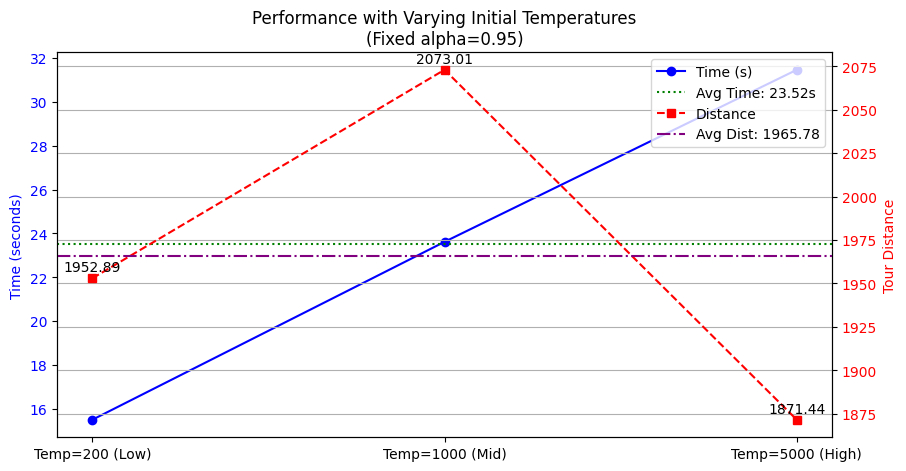

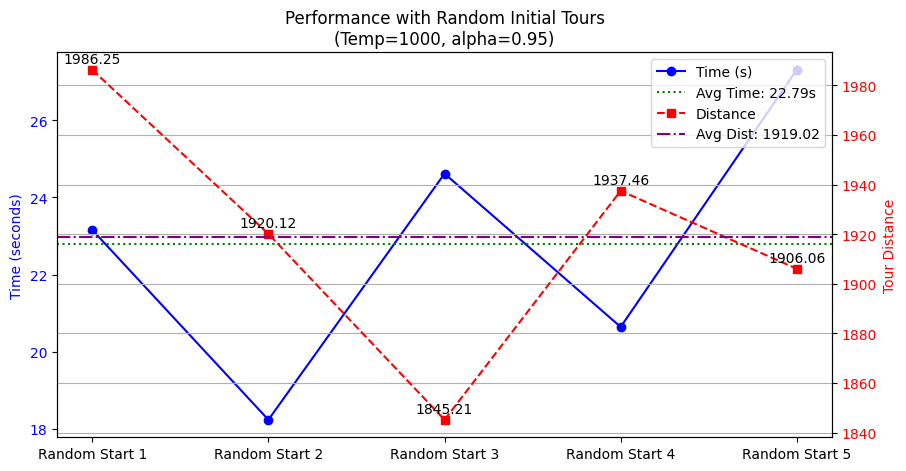

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import os
import shutil
import imageio
import time

def function_parse_tsp(file_path):
    """Parses a .tsp file and extracts city coordinates."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = []
    node_coord_section = False

    for line in lines:
        if line.startswith('NODE_COORD_SECTION'):
            node_coord_section = True
            continue
        if line.startswith('EOF'):
            break
        if node_coord_section:
            parts = line.strip().split()
            coordinates.append((float(parts[1]), float(parts[2])))
    return coordinates

def calculate_distance_matrix(coordinates):
    """Calculates the Euclidean distance matrix for a list of coordinates."""
    num_cities = len(coordinates)
    distance_matrix = np.zeros((num_cities, num_cities))

    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = np.linalg.norm(
                np.array(coordinates[i]) - np.array(coordinates[j]))
    return distance_matrix

def total_distance(tour, dist_matrix):
    """Computes the total distance of a TSP tour."""
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += dist_matrix[tour[i]][tour[i + 1]]
    total_distance += dist_matrix[tour[-1]][tour[0]]
    return total_distance

def get_neighbors(tour):
    """Generates neighbor tours by swapping every possible pair of cities."""
    neighbors = []
    for i in range(len(tour)):
        for j in range(i + 1, len(tour)):
            neighbor = tour.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append(neighbor)
    return neighbors

def is_valid_tsp_tour(tour, num_cities):
    """Validates that the tour includes all cities exactly once."""
    return len(tour) == num_cities and set(tour) == set(range(num_cities))

def plot_tour_gif(coords, tour, step, folder='frames'):
    """Plots the current tour and saves the frame as an image."""
    coords_arr = np.array([coords[i] for i in tour + [tour[0]]])

    plt.figure(figsize=(6, 4))
    plt.plot(coords_arr[:, 0], coords_arr[:, 1], 'b-', marker='o')
    for i, (x, y) in enumerate(coords_arr[:-1]):
        plt.text(x, y, str(tour[i]), fontsize=8, color='red')
    plt.title(f"Simulated Annealing Step {step}")
    plt.grid(True)
    os.makedirs(folder, exist_ok=True)
    filename = os.path.join(folder, f'step_{step:03d}.png')
    plt.savefig(filename)
    plt.close()

def generate_gif(frame_folder='frames', output_file='simulated_annealing_tsp.gif'):
    """Compiles saved frames into a GIF."""
    images = []
    files = sorted(os.listdir(frame_folder))
    for file in files:
        if file.endswith('.png'):
            img_path = os.path.join(frame_folder, file)
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_file, images, duration=0.5)
    print(f"GIF saved as {output_file}")

def clear_frame_folder(folder='frames'):
    """Clears or creates the frame folder for GIF generation."""
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

def simulated_annealing_tsp(
    coords,
    initial_tour=None,  # Optional: If None, generates a new random tour
    initial_temp=1000,
    stopping_temp=1,
    alpha=0.99,
    epsilon=1e-6,
    max_iter=1000,
    folder='frames'
):
    """Solves the TSP using Simulated Annealing."""
    dist_matrix = calculate_distance_matrix(coords)
    num_cities = len(coords)

    # Use provided initial tour or generate a new one
    current_tour = initial_tour.copy() if initial_tour else list(range(num_cities))
    if initial_tour is None:
        random.shuffle(current_tour)
    assert is_valid_tsp_tour(current_tour, num_cities), "Initial tour is invalid!"

    current_dist = total_distance(current_tour, dist_matrix)
    best_tour = current_tour.copy()
    best_dist = current_dist

    t = initial_temp
    accepted_steps = 0
    total_steps = 0

    plot_tour_gif(coords, current_tour, accepted_steps, folder)

    while t >= stopping_temp and total_steps < max_iter:
        total_steps += 1
        candidate_tour = get_neighbors(current_tour)
        next_tour = random.choice(candidate_tour)
        assert is_valid_tsp_tour(next_tour, num_cities), f"Invalid neighbor at step {total_steps}!"

        next_dist = total_distance(next_tour, dist_matrix)
        delta = next_dist - current_dist

        if delta < 0 or random.random() < math.exp(-delta / t):
            current_tour = next_tour.copy()
            current_dist = next_dist
            accepted_steps += 1
            plot_tour_gif(coords, current_tour, accepted_steps, folder)

            if current_dist < best_dist:
                best_tour = current_tour.copy()
                best_dist = current_dist

        t *= alpha

    return best_tour, best_dist, accepted_steps, total_steps

# --- MAIN EXECUTION ---
path = '/content/ant_colony_opt_TSP/problems_cleaned/eil76.tsp'
coords = function_parse_tsp(path)
num_cities = len(coords)

# --- PART 1: 6 ITERATIONS WITH SAME START, DIFFERENT SA SETTINGS ---
print("\n=== Running 6 iterations with fixed initial tour, varying alpha and temp separately ===")
initial_tour = list(range(num_cities))
random.shuffle(initial_tour)

# Experiment A: Vary alpha (fixed temp)
alpha_configs = [
    {"initial_temp": 1000, "alpha": 0.99, "label": "Alpha=0.99 (Slow)"},
    {"initial_temp": 1000, "alpha": 0.95, "label": "Alpha=0.95 (Medium)"},
    {"initial_temp": 1000, "alpha": 0.90, "label": "Alpha=0.90 (Fast)"},
]

# Experiment B: Vary temp (fixed alpha)
temp_configs = [
    {"initial_temp": 200,  "alpha": 0.95, "label": "Temp=200 (Low)"},
    {"initial_temp": 1000, "alpha": 0.95, "label": "Temp=1000 (Mid)"},
    {"initial_temp": 5000, "alpha": 0.95, "label": "Temp=5000 (High)"},
]

# Store results for plotting
alpha_results = []
temp_results = []
random_results = []

# Run alpha experiments
print("\n--- Varying Alpha Experiments ---")
for i, config in enumerate(alpha_configs, 1):
    print(f"Running with config: {config['label']}")
    folder = f'frames_alpha_{config["alpha"]}'
    clear_frame_folder(folder)

    start_time = time.time()
    tour, dist, steps, total_steps = simulated_annealing_tsp(
        coords,
        initial_tour=initial_tour,
        initial_temp=config["initial_temp"],
        alpha=config["alpha"],
        folder=folder
    )
    elapsed = time.time() - start_time

    alpha_results.append({
        "label": config["label"],
        "distance": dist,
        "time": elapsed,
        "steps": steps,
        "total_steps": total_steps
    })
    print(f"  Distance: {dist:.2f} | Time: {elapsed:.2f}s")
    generate_gif(frame_folder=folder, output_file=f'sa_alpha_{i}.gif')

# Run temperature experiments
print("\n--- Varying Temperature Experiments ---")
for i, config in enumerate(temp_configs, 1):
    print(f"Running with config: {config['label']}")
    folder = f'frames_temp_{config["initial_temp"]}'
    clear_frame_folder(folder)

    start_time = time.time()
    tour, dist, steps, total_steps = simulated_annealing_tsp(
        coords,
        initial_tour=initial_tour,
        initial_temp=config["initial_temp"],
        alpha=config["alpha"],
        folder=folder
    )
    elapsed = time.time() - start_time

    temp_results.append({
        "label": config["label"],
        "distance": dist,
        "time": elapsed,
        "steps": steps,
        "total_steps": total_steps
    })
    print(f"  Distance: {dist:.2f} | Time: {elapsed:.2f}s")
    generate_gif(frame_folder=folder, output_file=f'sa_temp_{i}.gif')

# --- PART 2: 5 ITERATIONS WITH RANDOM STARTS, BASELINE SA SETTINGS ---
print("\n=== Running 5 iterations with random initial tours ===")
baseline_config = {"initial_temp": 1000, "alpha": 0.95}

for run in range(1, 6):
    print(f"Running Iteration #{run}...")
    folder = f'frames_random_{run}'
    clear_frame_folder(folder)

    start_time = time.time()
    tour, dist, steps, total_steps = simulated_annealing_tsp(
        coords,
        initial_temp=baseline_config["initial_temp"],
        alpha=baseline_config["alpha"],
        folder=folder
    )
    elapsed = time.time() - start_time

    random_results.append({
        "label": f"Random Start {run}",
        "distance": dist,
        "time": elapsed,
        "steps": steps,
        "total_steps": total_steps
    })
    print(f"  Distance: {dist:.2f} | Time: {elapsed:.2f}s")
    generate_gif(frame_folder=folder, output_file=f'sa_random_{run}.gif')

# --- PLOT RESULTS ---
def plot_metrics_comparison(data, title, xlabel, filename=None):
    """Helper function to plot metrics comparison as line plots with average time"""
    plt.figure(figsize=(10, 5))

    x = [d['label'] for d in data]
    time_values = [d['time'] for d in data]
    distance_values = [d['distance'] for d in data]

    avg_time = sum(time_values) / len(time_values)
    avg_distance = sum(distance_values) / len(distance_values)

    # Plot time on primary axis
    time_line, = plt.plot(x, time_values, 'bo-', label='Time (s)')
    plt.ylabel('Time (seconds)', color='b')
    plt.tick_params(axis='y', labelcolor='b')

    avg_line = plt.axhline(y=avg_time, color='green', linestyle=':',
                          label=f'Avg Time: {avg_time:.2f}s')

    # Plot distance on secondary axis
    ax2 = plt.twinx()
    distance_line, = ax2.plot(x, distance_values, 'rs--', label='Distance')
    ax2.set_ylabel('Tour Distance', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    avg_dist_line = ax2.axhline(y=avg_distance, color='purple', linestyle='-.',
                               label=f'Avg Dist: {avg_distance:.2f}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid(True)

    # Add value labels
    for i, txt in enumerate(time_values):
        plt.annotate(f"{txt:.2f}s", (x[i], time_values[i]),
                    textcoords="offset points", xytext=(0,5), ha='center')

    for i, txt in enumerate(distance_values):
        ax2.annotate(f"{txt:.2f}", (x[i], distance_values[i]),
                    textcoords="offset points", xytext=(0,5), ha='center')

    lines = [time_line, avg_line, distance_line, avg_dist_line]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels)

    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

# Plot 1: Varying Alpha (fixed temp)
plot_metrics_comparison(
    alpha_results,
    "Performance with Varying Cooling Rates\n(Fixed Temperature=1000)",
    "Cooling Rate (alpha)",
    filename="alpha_metrics_comparison.png"
)

# Plot 2: Varying Temp (fixed alpha)
plot_metrics_comparison(
    temp_results,
    "Performance with Varying Initial Temperatures\n(Fixed alpha=0.95)",
    "Initial Temperature",
    filename="temp_metrics_comparison.png"
)

# Plot 3: Random Starts (fixed settings)
plot_metrics_comparison(
    random_results,
    "Performance with Random Initial Tours\n(Temp=1000, alpha=0.95)",
    "Run Instance",
    filename="random_starts_metrics_comparison.png"
)